## Learning outcomes
1. Image histogram : distribution grayscale values
2. Enhance constrast: scalar multiplication on image, histogram equalization and its variant called CLAHE.
3. Thresholding:global thresholding and otsu thresholding
4. Morphological operations (limit our discussion on binary image)
5. Color spaces: HSV color space used to perform color based segmentation.

## Setup

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Image histogram

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [3]:
# There are 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256])
%timeit hist, _ = np.histogram(gray.flatten(), 256)

20.4 µs ± 277 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
719 µs ± 4.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


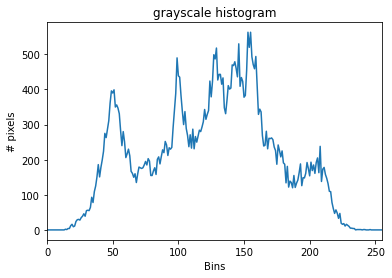

In [6]:
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

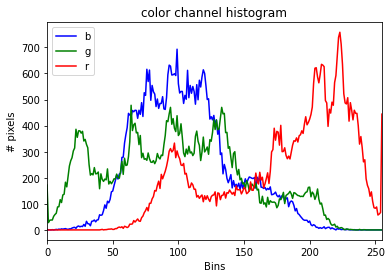

In [8]:
# get the histogram for every channel
channels = cv.split(img)
colors = ("b", "g", "r")
plt.figure()
plt.title("color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label=color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()

In [9]:
img = cv.imread("images/low_contrast_img.jfif", 0)
show_img("low constrast", img)

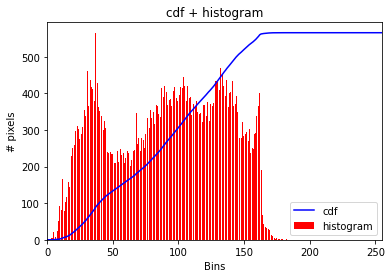

In [13]:
# histogram for this image
hist = cv.calcHist([img], [0], None, [256], [0, 256])

# cdf
cdf = hist.cumsum()
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(img.flatten(), 256, color="r")
plt.title("cdf + histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0,255])
plt.show()

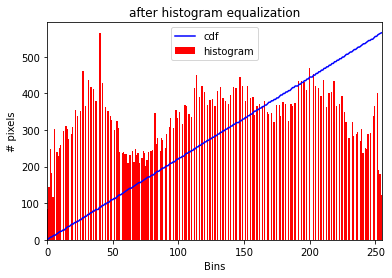

In [14]:
# histogram equalization
eq = cv.equalizeHist(img)

hist = cv.calcHist([eq], [0], None, [256], [0, 256])

# cdf
cdf = hist.cumsum()
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(eq.flatten(), 256, color="r")
plt.title("after histogram equalization")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0,255])
plt.show()

In [19]:
# CLAHE
img = cv.imread("images/dog1.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
#CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize = (8,8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Exercise 1
Try histogram equalization and CLAHE on 'winter.jfif' and display the results together with the original grayscale image. Comment on the results obtained.

In [20]:
img = cv.imread("images/winter.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
#CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize = (8,8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Thresholding

In [21]:
# simple global thresholding
# different types of thresholding
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [24]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype=np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2, img3, img4, img5)))
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Simple global threshold vs Otsu thresholding

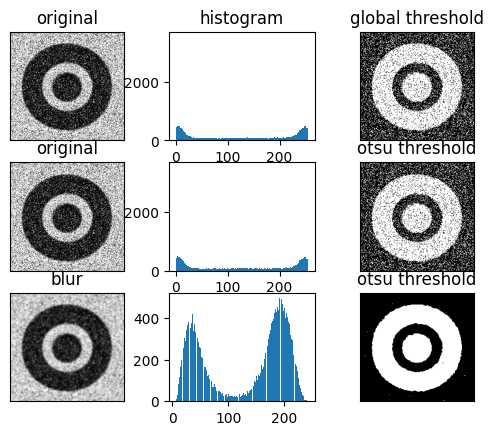

In [48]:
# apply 3 approaches: 1. global threshold, 2. otsu threshold, 3. blurring + otsu threshold
img = cv.imread("images/noisy.jfif", 0)

#1:
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

#2:
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3:
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold", 
          "original", "", "otsu threshold", 
          "blur", "", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
plt.show()

## Morphological operations

In [86]:
# kernel
kernel = np.ones((3, 4,), np.uint8)

# erosion
erosion = cv.erode(th3, kernel, iterations=1)

# combined
img_combined = np.hstack((th3, erosion))

show_img("erosion", img_combined)

In [51]:
# trackbar: function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while (1):
    # retrieve the size and # iteration
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
    
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        

    kernel = np.ones((size, size), dtype=np.uint8)
    # closing
    closing = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel, iterations=iteration)
    
    cv.imshow(wn, closing)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

In [35]:
cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

## Color spaces
- RGB / BGR (prevalent image formats)
- HSV (hue, saturation, value)
    * hue encodes color (angular, 0-360). In OpenCV, 0-179
    * saturation implies color purity
    * value: brightness. 0 is dark.
- L\*a\*b:
    - L denotes brightness / luminance while a and b are color channels.
    - perceptual uniformity

In [36]:
# sharpen
img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

l, a ,b = cv.split(img_lab)

# process just the l channel
# sharpen
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
l_sharpen = cv.filter2D(l, -1, kernel)

# merge
sharpen = cv.merge((l_sharpen, a, b))

# change to bgr
sharpen = cv.cvtColor(sharpen, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", sharpen)

## Demo on color based segmentation

In [111]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

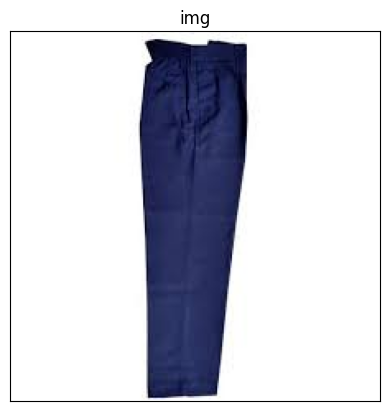

In [5]:
plt_img(img, "img")

In [3]:
## import depencies
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

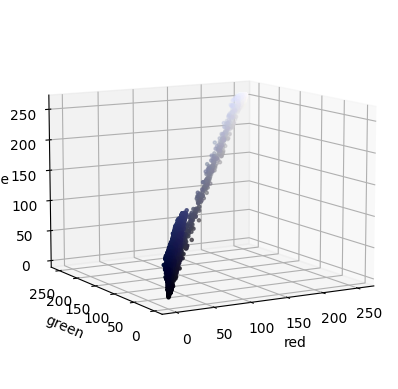

In [113]:
# split the image into separate channels
r, g, b = cv.split(img)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel colors ready as argument for scatter plot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=240)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

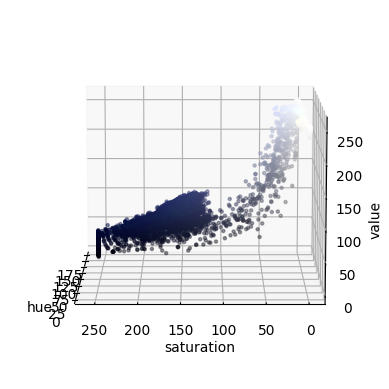

In [119]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=180)
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

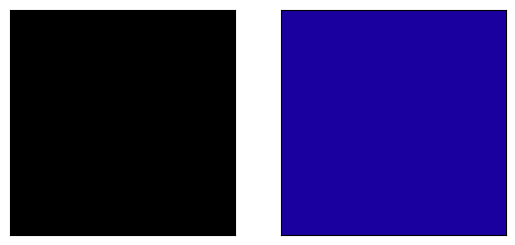

In [9]:
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

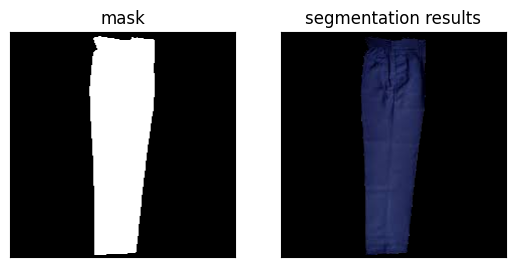

In [10]:
# color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)
plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation results")
plt.show()

## Exercise
- Does the segmentation generalize to other blue pant images?
    - Import all blue pant images ("pant1.jfif" - "pant5.jfif")
    - Perform color segmentation
    - Display the results

In [11]:
def color_seg(img, color_low, color_high, smooth=True):
    """Args:
    img:source image
    color_low and color_high are tuple of colors
    smooth is boolean (blurring or not)"""
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    # change from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    # mask
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    
    return cv.bitwise_and(ori_img, ori_img, mask=mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

# perform color segmentation
res = [color_seg(im, blue_low, blue_high) for im in imgs]

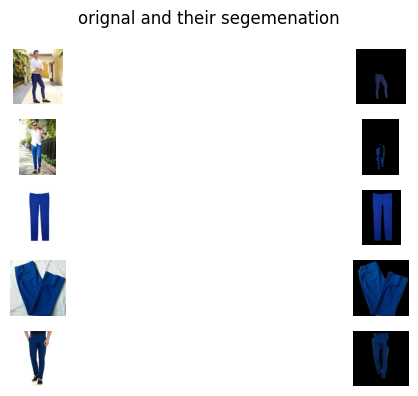

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(10, 4))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("orignal and their segemenation")
plt.tight_layout()
plt.show()

## Weekly Activity 1
1. Write a program to segment the boat and the people on it from the background. Follow the instruction below:
    - Use 'boat.jpg' as input.
    - Apply Otsu thresholding.
    - Draw bounding box to identify the region where the boat and people are located.

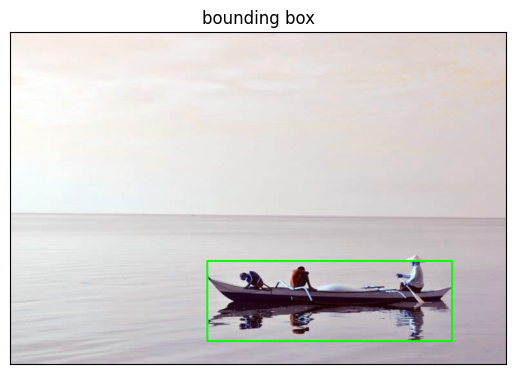

In [70]:
img = cv.imread("images/boat.jpg")
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

th = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

contours = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

img_copy = img.copy()

for contour in contours:
    # adjust threshold
    if cv.contourArea(contour) > 500:
        x, y, w, h = cv.boundingRect(contour)
        cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt_img(img_copy, "bounding box")

## Weekly Activity 2
2. Write a program to visualize the effect of size of structuring element on the morphological transformation (e.g. erosion, dilation, opening, and closing).
    - Load the 'leaf.jfif' and perform thresholding to segment the leaf from the background.
    - Create a GUI containing trackbar to control the size of structuring element and display the resulting image on a window alongside the trackbar.

In [96]:
img = cv.imread("images/leaf.jfif", 0)

th = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while (1):
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
    
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        

    kernel = np.ones((size, size), dtype=np.uint8)

    erosion = cv.erode(th, kernel, iterations=iteration)
    dilation = cv.dilate(th, kernel, iterations=iteration)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=iteration)
    closing = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel, iterations=iteration)

    img_combined = np.hstack((erosion, dilation, opening, closing))
    
    cv.imshow(wn, img_combined)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

## Weekly Activity 3
3. Apply the steps shown in exercise 4 to segment the porcelain from these images: "porcelain1.jfif" - "porcelain5.jfif".

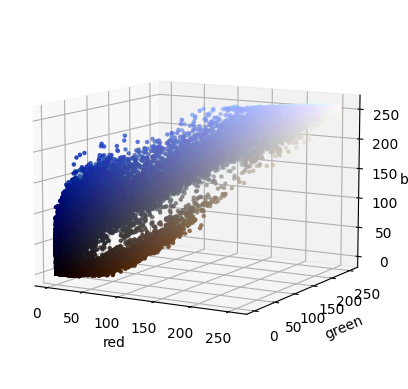

In [64]:
img = cv.imread("images/color_space/porcelain2.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# split the image into separate channels
r, g, b = cv.split(img)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel colors ready as argument for scatter plot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=300)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

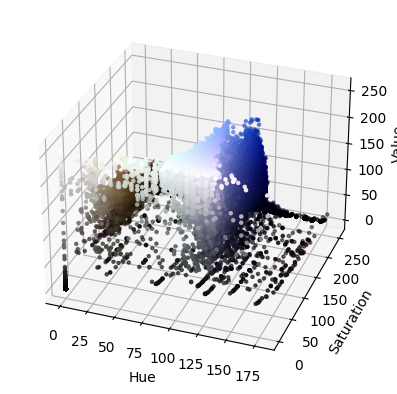

In [67]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(), 
            facecolors=pixel_colors, marker=".")
axis.view_init(elev=30, azim=290)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

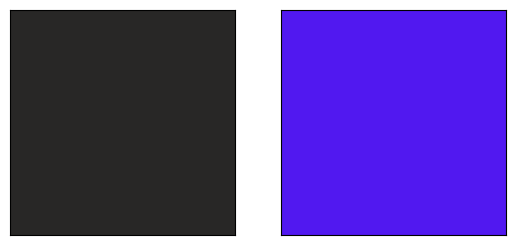

In [273]:
porcelain_low = (20, 14, 40)
porcelain_high = (128,230,240)

square1 = np.full((10, 10, 3), porcelain_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), porcelain_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

In [274]:
def color_seg(img, color_low, color_high, smooth=True):
    """Args:
    img:source image
    color_low and color_high are tuple of colors
    smooth is boolean (blurring or not)"""
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    # change from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    # mask
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    
    return cv.bitwise_and(ori_img, ori_img, mask=mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

# perform color segmentation
res = [color_seg(im, porcelain_low, porcelain_high) for im in imgs]

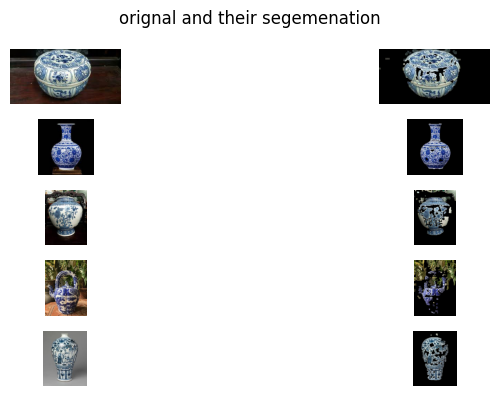

In [275]:
fig, ax = plt.subplots(5, 2, figsize=(10, 4))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("orignal and their segemenation")
plt.tight_layout()
plt.show()